In [1]:
import numpy as np
import datasets
import pandas as pd
import matplotlib.pyplot as plt 
import sys
sys.path.append('../')
from scripts.utils import WindowedRollingDistance, generate_xticks
from scripts.signal_utils import remove_artist, calc_signals, plot_novelty_signal, plot_resonance_signal
from scripts.utils import calc_vector_histogram
from PIL import Image
from scipy.ndimage import gaussian_filter1d
import numpy as np
from tslearn.metrics import dtw

/work/golden-imprints/change_detection/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/work/golden-imprints/change_detection/env/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
# load smk dataset
ds = datasets.load_from_disk('../data/smk_subset_embeddings')

In [3]:
# load signal df (w_size = 20)
org_signal = pd.read_csv('../data/signals/signal_df.csv')

In [5]:
def calc_signal_difference(no_artist_signal_df, org_signal, w_size):

    # convert the novelty signal excluding a specific artist to a list
    n_df = no_artist_signal_df.iloc[w_size:, :]
    n_hat = n_df['N_hat'].tolist()

    # do the same for the original novelty signal
    n_df_original = org_signal.iloc[w_size:, :]
    n_hat_original = n_df_original['N_hat'].tolist()

    # calculate dtw (Dynamic Time Warping) difference
    dtw_score_n = dtw(n_hat, n_hat_original)

    # convert the resonance signal excluding a specific artist to a list
    r_df = no_artist_signal_df.iloc[w_size:-w_size, :]
    r_hat = r_df['R_hat'].tolist()

    # do the same for the original resonance signal
    r_df_original = org_signal.iloc[w_size:-w_size, :]
    r_hat_original = r_df_original['R_hat'].tolist()

    # calculate difference
    dtw_score_r = dtw(r_hat, r_hat_original)

    return dtw_score_n, dtw_score_r

In [16]:
def calc_dtw_scores(ds, artist, w_size, org_signal):

    # remove artist from data
    ds_no_artist = remove_artist(ds, artist)

    # calculate new signal with artist removed
    signal_df = calc_signals(ds_no_artist, w_size)

    # calculate dtw scores for novelty and resonance for the new and original signal
    dtw_score_n, dtw_score_r = calc_signal_difference(signal_df, org_signal, w_size)

    return dtw_score_n, dtw_score_r

In [4]:
# add information about artist
org_signal['artist'] = ds['artist']

# create grouped object and convert to dataframe
grouped = org_signal.groupby(['artist'])['N_hat'].describe()
grouped_df = grouped.reset_index()

In [18]:
# calculate dtw for each artist
dtw_n = []
dtw_r = []

for artist in grouped_df['artist']:
    dtw_scores = calc_dtw_scores(ds, artist, 20, org_signal) # using window size of 20

    dtw_n.append(dtw_scores[0])
    dtw_r.append(dtw_scores[1])

KeyboardInterrupt: 

In [ ]:
# add to dataframe
grouped_df['dtw_n'] = dtw_n
grouped_df['dtw_r'] = dtw_r

In [ ]:
grouped_df.sort_values('dtw_n', ascending=False).tail(10)

,artist,count,mean,std,min,25%,50%,75%,max,dtw_n,dtw_r
96,Johann Georg Wahl,1.0,0.313611,NaN,0.313611,0.313611,0.313611,0.313611,0.313611,0.041995,0.046665
63,Friedrich Thøming,1.0,0.278699,NaN,0.278699,0.278699,0.278699,0.278699,0.278699,0.041982,0.047796
25,Carl Bøgh,1.0,0.322149,NaN,0.322149,0.322149,0.322149,0.322149,0.322149,0.039371,0.051949
91,Johan Anton Bech,1.0,0.295718,NaN,0.295718,0.295718,0.295718,0.295718,0.295718,0.039206,0.055683
11,Benny Bendixen,1.0,0.308006,NaN,0.308006,0.308006,0.308006,0.308006,0.308006,0.038258,0.050962
127,Vilhelm Melbye,1.0,0.284934,NaN,0.284934,0.284934,0.284934,0.284934,0.284934,0.037445,0.056534
12,Birgitte Levison,1.0,0.287249,NaN,0.287249,0.287249,0.287249,0.287249,0.287249,0.036291,0.045343
51,Emil Andersen,1.0,0.321872,NaN,0.321872,0.321872,0.321872,0.321872,0.321872,0.031861,0.061990
115,Peter Copmann,1.0,0.288120,NaN,0.288120,0.288120,0.288120,0.288120,0.288120,0.027001,0.036204
116,Peter Julius Larsen,1.0,0.310334,NaN,0.310334,0.310334,0.310334,0.310334,0.310334,0.026801,0.042191


In [ ]:
grouped_df.to_csv('../data/signals/grouped_dtw.csv')

Text(0, 0.5, 'DTW similarity value for Novelty')

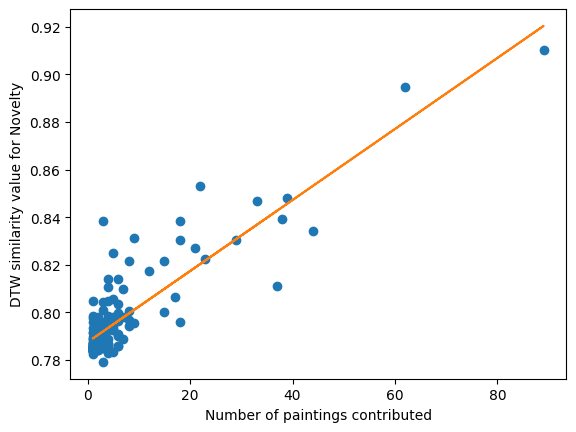

In [ ]:
from sklearn.linear_model import LinearRegression

X = np.array(grouped_df['count']).reshape((-1, 1))
y = np.array(grouped_df['dtw_n'])

model = LinearRegression().fit(X, y)

plt.plot(X, y, 'o')
plt.plot(X, model.coef_[0]*X+model.intercept_)
plt.xlabel('Number of paintings contributed')
plt.ylabel('DTW similarity value for Novelty')

In [ ]:
grouped_df.sort_values('dtw_r', ascending=False)

,artist,count,mean,std,min,25%,50%,75%,max,dtw_n,dtw_r
43,Constantin Hansen,44.0,0.360664,0.068871,0.275740,0.314533,0.338678,0.395288,0.555242,0.834222,0.900635
16,C.A. Lorentzen,23.0,0.332972,0.074425,0.243314,0.277551,0.305593,0.376551,0.493516,0.822457,0.884021
111,Nicolai Abildgaard,18.0,0.211016,0.156450,0.000000,0.000000,0.304486,0.324741,0.399401,0.838416,0.881328
2,Albert Küchler,8.0,0.403018,0.088513,0.300010,0.326305,0.407743,0.453706,0.560044,0.821405,0.877503
130,Wilhelm Marstrand,37.0,0.358075,0.047502,0.280162,0.322659,0.348728,0.391547,0.477684,0.810863,0.873649
...,...,...,...,...,...,...,...,...,...,...,...
1,Adam Müller,4.0,0.438598,0.034745,0.403882,0.411506,0.438461,0.465553,0.473588,0.798496,0.842767
32,Carlo Dalgas,4.0,0.400907,0.128994,0.247228,0.331090,0.402807,0.472623,0.550785,0.813894,0.842612
93,Johan Friedrich Fritz,1.0,0.500849,NaN,0.500849,0.500849,0.500849,0.500849,0.500849,0.783523,0.842395
123,Thorald Læssøe,9.0,0.432583,0.103026,0.313912,0.362426,0.405870,0.553508,0.573465,0.831269,0.842106


Text(0, 0.5, 'DTW similarity value for Resonance')

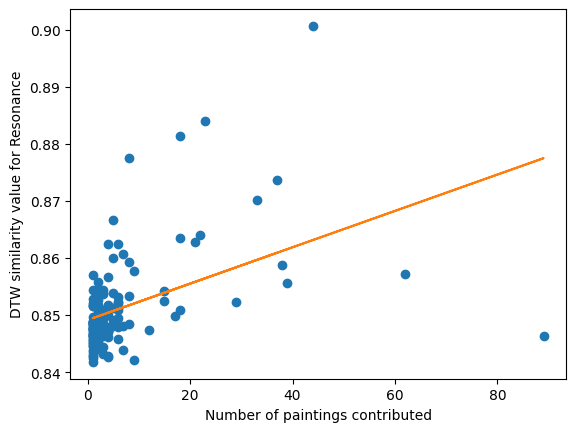

In [ ]:
X = np.array(grouped_df['count']).reshape((-1, 1))
y = np.array(grouped_df['dtw_r'])

model = LinearRegression().fit(X, y)
plt.plot(X, y, 'o')
plt.plot(X, model.coef_[0]*X+model.intercept_)
plt.xlabel('Number of paintings contributed')
plt.ylabel('DTW similarity value for Resonance')

### Find two comparable artists

In [4]:
# load data
grouped_df = pd.read_csv('../data/signals/grouped_dtw.csv')

In [ ]:
grouped_df.query('20 > count > 10').head(10)

,Unnamed: 0,artist,count,mean,std,min,25%,50%,75%,max,dtw_n,dtw_r
47,47,Ditlev Blunck,12.0,0.378167,0.108792,0.294305,0.306976,0.343310,0.387147,0.663770,0.310106,0.275487
66,66,Fritz Thomsen,18.0,0.431076,0.089796,0.291741,0.360413,0.432291,0.468188,0.649734,0.454904,0.312081
104,104,Jørgen V. Sonne,18.0,0.382332,0.081198,0.290607,0.306740,0.385436,0.420090,0.546272,0.298565,0.259103
105,105,Lorenz Frølich,17.0,0.338171,0.059395,0.243845,0.306052,0.322361,0.355170,0.490487,0.242423,0.223478
108,108,Martinus Rørbye,15.0,0.368102,0.084779,0.262868,0.323468,0.343084,0.389270,0.585234,0.243101,0.266668
111,111,Nicolai Abildgaard,18.0,0.211016,0.156450,0.000000,0.000000,0.304486,0.324741,0.399401,0.457569,0.172190
126,126,Vilhelm Kyhn,15.0,0.398652,0.071356,0.318554,0.348488,0.379764,0.429350,0.596511,0.317918,0.275484


nicolai abildgaard (semi-high dtw), Lorenz Frølich (semi-low dtw)

In [ ]:
grouped_df.query('10 > count > 5').head(10)

,Unnamed: 0,artist,count,mean,std,min,25%,50%,75%,max,dtw_n,dtw_r
2,2,Albert Küchler,8.0,0.403018,0.088513,0.300010,0.326305,0.407743,0.453706,0.560044,0.263474,0.205784
7,7,Anthon Christoffer Rüde,6.0,0.142938,0.157132,0.000000,0.000000,0.135138,0.275978,0.309475,0.162934,0.104819
34,34,Christen Dalsgaard,6.0,0.348215,0.046756,0.275443,0.319871,0.365111,0.378964,0.395253,0.118296,0.175551
37,37,Christian David Gebauer,6.0,0.391216,0.059518,0.347491,0.353607,0.366315,0.402829,0.502801,0.218320,0.189734
38,38,Christian Holm,6.0,0.344265,0.041902,0.283390,0.331002,0.342533,0.354433,0.411573,0.161673,0.159079
55,55,Ernst Meyer,8.0,0.357709,0.075411,0.273102,0.317501,0.337432,0.375633,0.520148,0.154564,0.166550
56,56,F. Sødring,8.0,0.450443,0.096475,0.347636,0.389882,0.422080,0.498399,0.629134,0.284196,0.243430
65,65,Fritz Petzholdt,7.0,0.443609,0.077469,0.334072,0.421848,0.440411,0.446137,0.594806,0.281386,0.217918
80,80,Henrich Christian From,6.0,0.342054,0.049773,0.291014,0.305853,0.332176,0.364987,0.423955,0.267281,0.156299
82,82,Hermania Neergaard,7.0,0.350970,0.047472,0.292887,0.316720,0.354813,0.372115,0.431422,0.164598,0.167928


F. Sødring ('high' dtw), Christen Dalsgaard, ('low' dtw)

### Remove single paintings and re-calculate DTW

In [9]:
# get list of the 5 biggest artists (== contributed the most paintings)
sorted_df_subset = grouped_df.sort_values('count', ascending=False).head(5)

biggest_artists = list(sorted_df_subset['artist'])
biggest_artists

['C.W. Eckersberg',
 'Christen Købke',
 'Constantin Hansen',
 'Johan Thomas Lundbye',
 'Dankvart Dreyer']

In [20]:
 def remove_random_paintings(org_signal, artist, random_state, ds, w_size):

    '''
    Iteratively sample n rows from a dataframe containing paintings from a specific artist, remove them from the total dataset
    and recalculate signals and Dynamic Time Warping differences.

    '''
    
    # initialize empty list
    dtws = []

    # filter df for given artist
    query_df = org_signal.query(f"artist == '{artist}'")

    # iterate over the length of the query df
    for n in list(range(1, len(query_df))):

        # sample n amount of rows
        sample = query_df.sample(n, random_state=2830)

        # remove these rows from the signal df
        df_paint_removed = org_signal.drop(list(sample.index))

        # select the remaining images from the huggingface dataset
        new_ds = ds.select(list(df_paint_removed.index))

        # recalculate novelty and resonance signals
        new_signal_df = calc_signals(new_ds, w_size)

        # recalculate Dynamic Time Warping distance for novelty
        dtw_n, _ = calc_signal_difference(new_signal_df, org_signal, w_size)

        dtws.append(dtw_n)

    return dtws

In [10]:
results = []
for artist in biggest_artists:
    result = remove_random_paintings(org_signal, artist, 2830, ds, 20)
    results.append(result)

In [12]:

def remove_random_paintings_small_artists(org_signal, paintings_count, seed, ds, w_size):
    '''
    Sample n paintings by artists who have contributed less paintings than the specified paintings_count variable. 
    The sampled paintings are removed and novelty and resonance signals are recalculated along with a dynamic time warping distance 
    measure for each n.  
    '''

    # initialize empty list
    dtws = []
    
    # group artist by paintings count
    grouped = org_signal.groupby(['artist'])['N_hat'].describe()
    grouped_df = grouped.reset_index() 

    # filter out artist with more paintings than the specified count
    small_artists = grouped_df.query(f'count <= {paintings_count}')
    small_artists = list(small_artists['artist'])

    # only get rows(paintings) from these artists
    small_artists_df = org_signal[org_signal['artist'].isin(small_artists)]

    # iterate over each value of n
    for n in list(range(1, len(small_artists_df))):

        # sample n rows
        sample = small_artists_df.sample(n, random_state=seed)

        # remove the sampled rows (paintings)
        df_paint_removed = org_signal.drop(list(sample.index))

        # create huggingface dataset where the sampled paintings are removed
        new_ds = ds.select(list(df_paint_removed.index))

        # recalculate signals
        new_signal_df = calc_signals(new_ds, w_size)

        # calculate dtw distance measure
        dtw_n, _ = calc_signal_difference(new_signal_df, org_signal, w_size)

        dtws.append(dtw_n)

    return dtws

In [13]:
small_results = remove_random_paintings_small_artists(org_signal, 2, 2830, ds, 20)

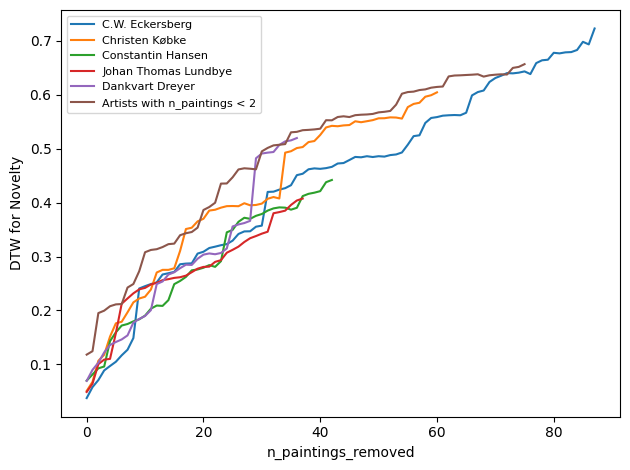

In [103]:
for i, v in enumerate(results):
    plt.plot(range(len(v)), v, label = biggest_artists[i])
plt.plot(range(len(small_results)), small_results, label = 'Artists with n_paintings < 2')
plt.ylabel('DTW for Novelty')
plt.xlabel('n_paintings_removed')
plt.legend(fontsize=8)
#plt.title('Dynamic Time Warping distance vs number of paintings removed')
plt.tight_layout()
plt.show()